# Lepton - Jet Asymmetry

### $\phi$ is defined as the angle between the total transverse momentum of the system,

### $\vec{q}_\perp = \vec{k}_{\ell\perp} + \vec{k}_{J\perp}$, 

### and the jet relative momentum,

### $\vec{P_\perp} = (\vec{k}_{\ell\perp} - \vec{k}_{J\perp})/2$

### Thus:

### $\cos(\phi) = (\vec{q}_\perp \cdot \vec{P_\perp})\ /\ |\vec{q}_\perp| |\vec{P_\perp}|$

### and $\phi = \mathrm{acos}[(\vec{q}_\perp \cdot \vec{P_\perp})\ /\ |\vec{q}_\perp| |\vec{P_\perp}|]$

### Assumption: Perturbative iff $\vec{q}_\perp << \vec{P_\perp}$

### Note: $\hat{t} = (k_l-k)^2 = -Q^2$

https://arxiv.org/pdf/2106.05307.pdf

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from matplotlib import gridspec
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import h5py

import os
os.environ['CUDA_VISIBLE_DEVICES']="3"

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

tf.config.experimental.set_memory_growth(physical_devices[0], True)

from matplotlib import style
style.use('/global/home/users/ftoralesacosta/dotfiles/scientific.mplstyle')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Read in Data and MC

In [2]:
data = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Data_nominal.pkl")
mc = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Rapgap_nominal.pkl")
#rapgap_df = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Rapgap_nominal.pkl")

### Select Leading Jets Only

In [5]:
one_jet_events_only = False
if (one_jet_events_only):
    data = data.loc[(slice(None),0), :]
    mc = mc.loc[(slice(None),0), :]
    print("Number of subjets cut = ",njets_tot-len(data["e_px"])," / ",len(data["jet_pt"]))

The above keeps only the first subentry. Because of the structure DF, this keeps the event and jet kinematics of the leading jets (index 0). More examples can be seen [here](https://riptutorial.com/pandas/example/26110/using--loc-and-slicers). Pandas MultiIndex docs are [here](https://awkward-array.org/how-to-convert-pandas.html?highlight=subentry)

### $\theta_{\mathrm{unknown}S}$

In [6]:
theta_unknown_S = data[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()
scaler_data = StandardScaler()
scaler_data.fit(theta_unknown_S)

StandardScaler()

### $\theta_{G}$

In [7]:
theta0_G = mc[['gene_px','gene_py','gene_pz','genjet_pt','genjet_eta','genjet_phi','genjet_dphi','genjet_qtnorm']].to_numpy()
weights_MC_sim = mc['wgt']
pass_reco = np.array(mc['pass_reco'])
pass_truth = np.array(mc['pass_truth'])
pass_fiducial = np.array(mc['pass_fiducial'])
del mc
_ = gc.collect()

In [8]:
print(np.sum(pass_fiducial)/len(pass_fiducial))

0.15491290270260472


### Step 2 NN Weights

In [9]:
NNweights_step2 = np.ones(len(theta0_G))
for i in range(5):
    mymodel = tf.keras.models.load_model("../../disjets/inputfiles/fullscan3/models/Rapgap_nominal_iteration"+str(i)+"_step2", compile=False)
    NNweights_step2_hold = mymodel.predict(scaler_data.transform(theta0_G),batch_size=10000)
    NNweights_step2_hold = NNweights_step2_hold/(1.-NNweights_step2_hold)
    NNweights_step2_hold = NNweights_step2_hold[:,0]
    NNweights_step2_hold = np.squeeze(np.nan_to_num(NNweights_step2_hold,posinf=1))
    NNweights_step2_hold[pass_truth==0] = 1.
    NNweights_step2 = NNweights_step2_hold*NNweights_step2

2022-10-19 15:15:16.346252: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 15:15:16.892483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22852 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:c1:00.0, compute capability: 7.5
2022-10-19 15:15:23.240193: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [10]:
weights = weights_MC_sim*NNweights_step2

---

### $\vec{q}_\perp = \vec{k}_{\ell\perp} + \vec{k}_{J\perp}$  and  $\vec{P_\perp} = (\vec{k}_{\ell\perp} - \vec{k}_{J\perp})/2$
### $\cos(\phi) = (\vec{q}_\perp \cdot \vec{P_\perp})\ /\ |\vec{q}_\perp| |\vec{P_\perp}|$

In [11]:
e_px = theta0_G[:,0]
e_py = theta0_G[:,1]

jet_pT_mag = theta0_G[:,3]
jet_phi = theta0_G[:,5]
print(min(jet_pT_mag))

jet_qT = theta0_G[:,7] #[not to be confused with q_Perp!]

print(min(jet_phi),max(jet_phi))
print(min(jet_pT_mag))

jet_px = np.multiply(jet_pT_mag, np.cos(jet_phi))
jet_py = np.multiply(jet_pT_mag, np.sin(jet_phi))

jet_pT = np.array([jet_px,jet_py])
e_pT = np.array([e_px,e_py])

q_perp_vec = jet_pT + e_pT
P_perp_vec = (e_pT-jet_pT)/2

q_perp_mag = np.linalg.norm(q_perp_vec,axis=0)
P_perp_mag = np.linalg.norm(P_perp_vec,axis=0)



q_dot_P = q_perp_vec[0,:]*P_perp_vec[0,:] + q_perp_vec[1,:]*P_perp_vec[1,:]

cosphi = (q_dot_P)/(q_perp_mag*P_perp_mag)
asymm_phi = np.arccos(cosphi)
#7.32459e-08 6.283185
print(np.shape(q_perp_mag))
print(np.shape(jet_phi))
print(np.shape(asymm_phi))

3.0
2.5982466e-08 6.283185
3.0
(84183898,)
(84183898,)
(84183898,)


/tmp/ipykernel_2546/1280418166.py:30: RuntimeWarning: invalid value encountered in arccos
  asymm_phi = np.arccos(cosphi)


### Define Cuts

In [22]:
#pass_fiducial created under theta_G
pT_cut = jet_pT_mag > 10.
q_over_pT_cut = q_perp_mag/jet_pT_mag < 0.3 #Kyle guessed ~0.3, needs variation
qT_cut = np.where((jet_qT<0.25), True, False)
phi_nan_cut = ~np.isnan(asymm_phi)
#q_perp_cut = q_perp_mag < 10.0 #q_perp_max

print(np.shape(pT_cut))
#print(np.shape(q_perp_cut))


cut_arrays = [pass_fiducial,
              pT_cut,
              q_over_pT_cut,
              qT_cut,
              phi_nan_cut]
              #q_perp_cut]

cuts = np.ones(len(pT_cut))

for cut in cut_arrays:
    print(len(cut))
    cuts = np.logical_and(cuts,cut)

(84183898,)
84183898
84183898
84183898
84183898
84183898


___

### Asymmetry Histogram

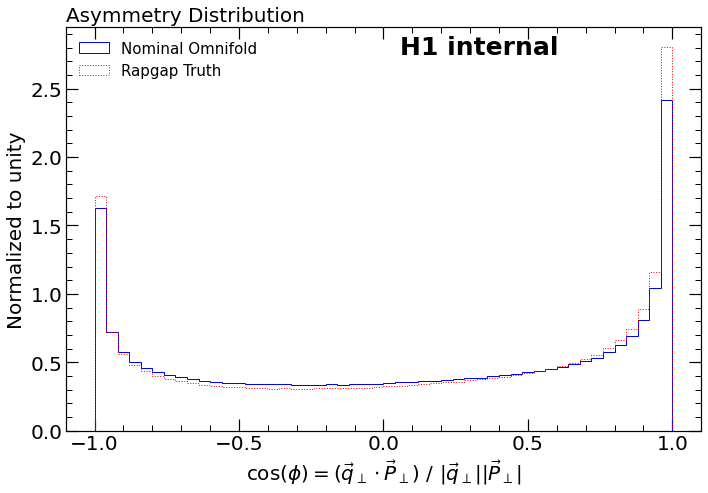

In [13]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=0)
plt.yticks(fontsize=20)
#bin_for_angle = np.linspace(0,3,18)
bin_for_angle = np.linspace(-1,1,51)

a_data,b_data,c=plt.hist(cosphi[cuts], bins = bin_for_angle,
                weights=weights_MC_sim[cuts]*NNweights_step2[cuts],
                density=True,histtype="step",color="blue",ls="-",label="Nominal Omnifold")

a_sim,b_sim,c=plt.hist(cosphi[cuts], bins = bin_for_angle,
                weights=weights_MC_sim[cuts],
                density=True,histtype="step",color="red",ls=":",label="Rapgap Truth")

plt.ylabel("Normalized to unity",fontsize=20)
plt.title("Asymmetry Distribution ",loc="left",fontsize=20)
plt.text(0.65, 0.95,'H1 internal', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.legend(frameon=False,fontsize=15,loc='upper left')
plt.locator_params(axis='x', nbins=5)
#plt.yscale("log")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20),

#plt.xlabel(r"$cos(\phi) = q_T\cdot e_{p_T}/(|q_T|\cdot|e_{p_T}|)$",fontsize=15)
plt.xlabel(r'cos($\phi) = (\vec{q}_\perp \cdot \vec{P}_\perp)\ /\ |\vec{q}_\perp| |\vec{P}_\perp|$',fontsize=20)

plt.savefig("H1_Angle_Distribution.pdf")
plt.tight_layout()
plt.show()

In [18]:
#np.save('from_rapgap_qT_masks',qT_masks)
np.save('from_rapgap_jet_pT.npy',jet_pT_mag)
np.save('from_rapgap_cuts.npy',cuts)
np.save('from_rapgap_q_perp.npy',q_perp_mag)
np.save('from_rapgap_asymm_angle.npy',asymm_phi)
np.save('from_rapgap_weights.npy',weights)
np.save("from_rapgap_nn_weights.npy",NNweights_step2)
np.save("from_rapgap_mc_weights.npy",weights_MC_sim)

In [15]:
print(len(cuts))
print(len(q_perp_mag))

84183898
84183898


In [23]:
cuts_h1rpgp       = np.load('from_rapgap_cuts.npy')
q_perp_h1rpgp     = np.load('from_rapgap_q_perp.npy')

In [24]:
print(len(cuts_h1rpgp))
print(len(q_perp_h1rpgp))

84183898
84183898
